<a href="https://colab.research.google.com/github/jadjadjade002/EsanCodingSs2-PersonalAI/blob/main/PMUB_Personal_AI_Image_classification_EfficientNetB5_Jadesadakorn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats vs Dogs : Image Classification using EfficienNet

## Data Description

**The training archive contains 25,000 images of dogs and cats.**


## Install

In [28]:
!pip install efficientnet

## Loading Libraries

> TensorFlow

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
from PIL import Image, ImageFile

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras import callbacks
from keras.callbacks import Callback
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from keras.optimizers import Adam
from efficientnet.keras import center_crop_and_resize, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [32]:
dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

## Data Extraction

In [33]:
data_dir = '/content/sample_data'
%cd '/content/sample_data'
!pwd

/content/sample_data
/content/sample_data


In [34]:
path_to_downloaded_file = tf.keras.utils.get_file(
    origin=dataset_url,
    extract=True,
)

In [35]:
path_to_downloaded_file

'/root/.keras/datasets/kagglecatsanddogs_5340.zip'

In [36]:
import zipfile

with zipfile.ZipFile(path_to_downloaded_file, 'r') as zipp:
    zipp.extractall(data_dir)

In [37]:
import glob

Cat_count = len(list(glob.glob(f'{data_dir}/PetImages/Cat/*.jpg')))
print('Cat: ', Cat_count)

Dog_count = len(list(glob.glob(f'{data_dir}/PetImages/Dog/*.jpg')))
print('Dog: ', Dog_count)

Cat:  12500
Dog:  12500


### Loading Images in a Dataframe

In [39]:
import glob
import pandas as pd

df_dada = pd.DataFrame(columns=['filename', 'label'])
list_dir = ["Cat", "Dog"]

# Create a list to store the DataFrames
df_list = []

for label in list_dir:
    filenames = list(glob.glob(f'{data_dir}/PetImages/{label}/*.jpg'))
    data = pd.DataFrame({"filename": filenames, "label": label})
    data = data.iloc[:1250,]
    # Append the DataFrame to the list
    df_list.append(data)

# Concatenate all DataFrames in the list
df_dada = pd.concat(df_list, ignore_index=True)

print(df_dada.shape)
df_dada.head()

(2500, 2)


filename label
0  /content/sample_data/PetImages/Cat/8660.jpg   Cat
1  /content/sample_data/PetImages/Cat/8379.jpg   Cat
2  /content/sample_data/PetImages/Cat/2654.jpg   Cat
3  /content/sample_data/PetImages/Cat/6897.jpg   Cat
4  /content/sample_data/PetImages/Cat/6155.jpg   Cat

## Data Exploration

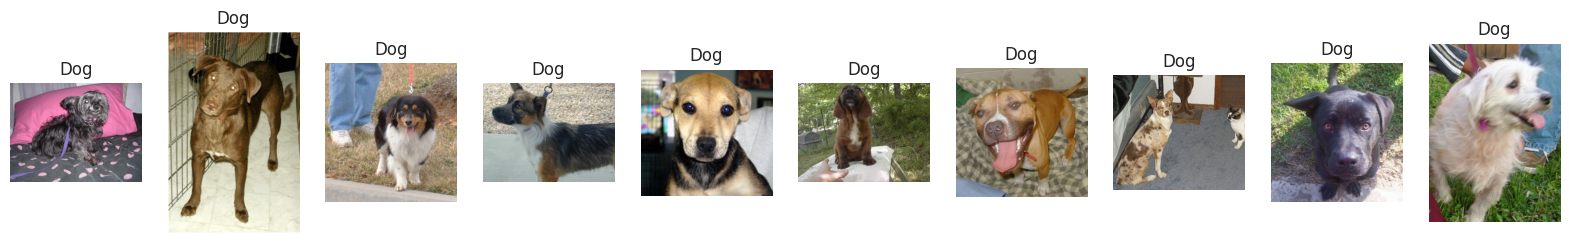

In [40]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = f'{data_dir}/PetImages/Dog/{str(i)}.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

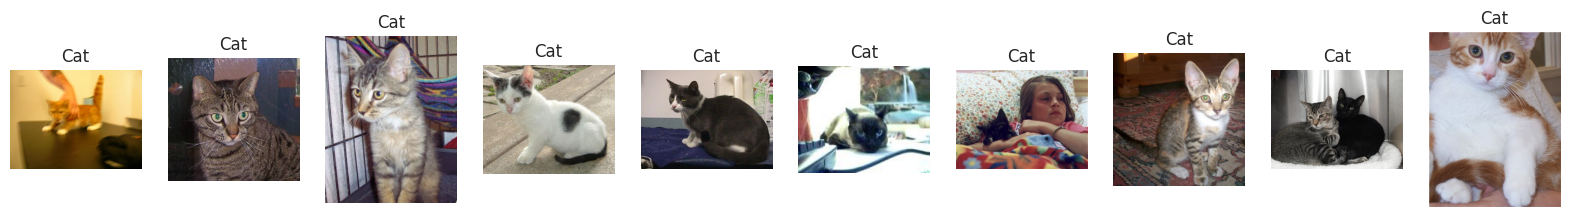

In [41]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = f'{data_dir}/PetImages/Cat/{str(i)}.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

### Train Test Split

In [42]:
# train test split using dataframe

labels = df_dada['label']

X_train, X_temp = train_test_split(df_dada, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (2000, 2)
The shape of test data (250, 2)
The shape of validation data (250, 2)


<ipython-input-43-418fb063fcee>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
<ipython-input-43-418fb063fcee>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
<ipython-input-43-418fb063fcee>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',w

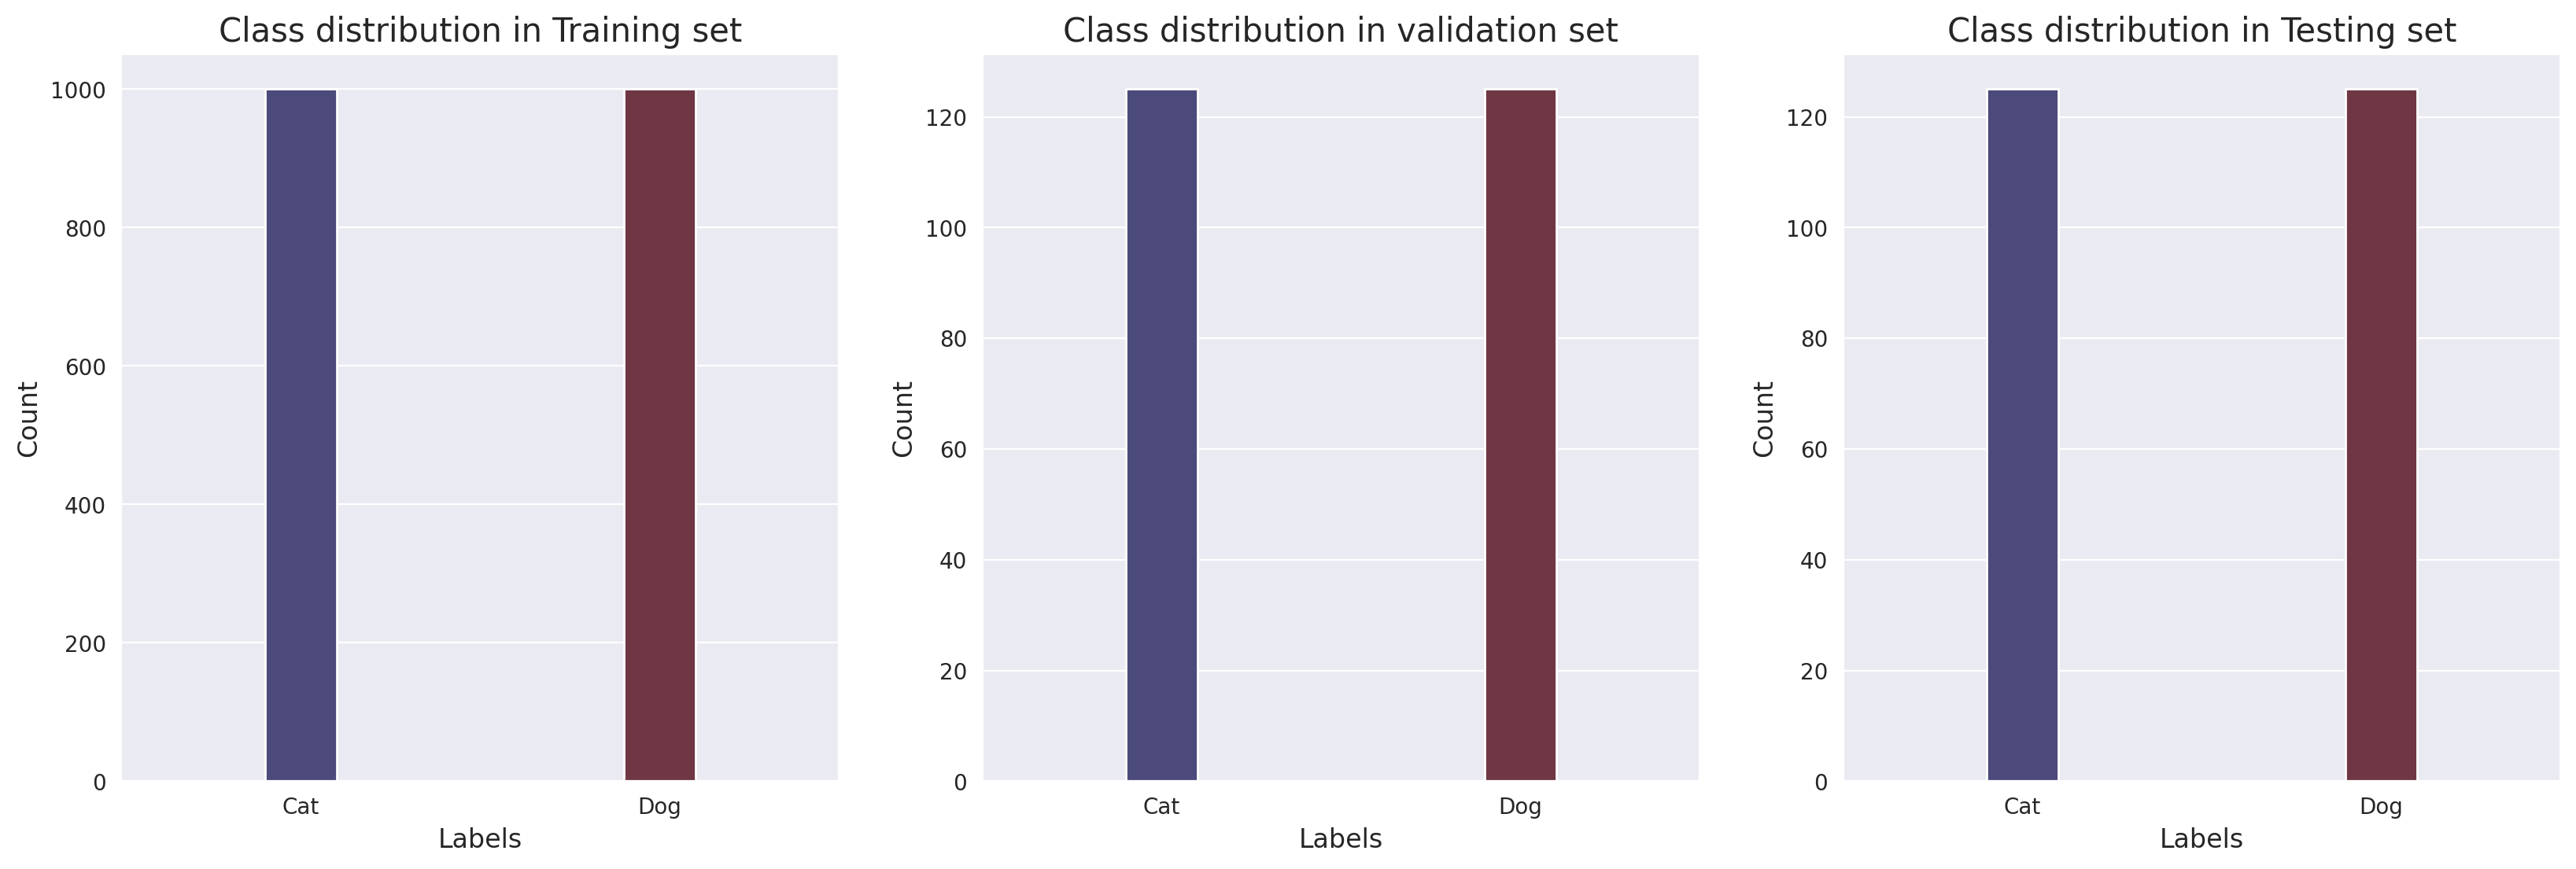

In [43]:
labels = ['Cat','Dog']

label1,count1 = np.unique(X_train.label,return_counts=True)
label2,count2 = np.unique(X_val.label,return_counts=True)
label3,count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

### Data Preparation

In [44]:
# parameters
target_size = (456, 456)
batch_size = 16

### Image Data Generator

-  The data for will used by flow_from_dataframe.

- The batch size is 16 and the image size is (456, 456).

In [45]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'nearest',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [46]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = None,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = batch_size,
                                                    target_size = target_size,
                                                    class_mode='categorical',
                                                    color_mode= 'rgb'
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = None,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = batch_size,
                                                 target_size = target_size,
                                                 class_mode='categorical',
                                                 color_mode= 'rgb'
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = None,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = batch_size,
                                                  target_size = target_size,
                                                  class_mode='categorical',
                                                  color_mode= 'rgb'
                                                 )

Found 2000 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


In [47]:
#label
labels = (train_generator.class_indices)
print(labels)

{'Cat': 0, 'Dog': 1}


In [49]:
import cv2
import PIL
from PIL import Image

%matplotlib inline
from matplotlib import pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(12, 15))
columns = 4
rows = 4

# Get the next batch of data using __next__()
x, y = train_generator.__next__()  # Change to __next__()

# You can also iterate

<Figure size 1200x1500 with 0 Axes>

## EfficienNet Model

In [50]:
# loading pretrained conv base model
from efficientnet.keras import EfficientNetB5 as Net

input_shape = (456, 456, 3)
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)
print(f"Input Shape: {input_shape}")

# create new model with a new classification layer
x = conv_base.output
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer = layers.Dropout(0.20,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(2, activation='softmax',name = 'predict_Cat_Dog')(dropout_layer)

### FC layer
model = models.Model(inputs= conv_base.input, outputs=prediction_layer, name = 'EffNet_Cat_Dog')

Input Shape: (456, 456, 3)


In [51]:
### Unfreeze FC layer
print('[INFO]: This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))
print('[INFO]: Freezing hidden layers...')
for layer in conv_base.layers:
    layer.trainable = False

print('[INFO]: This is the number of trainable layers '
        'after freezing the conv base:', len(model.trainable_weights))
print('-'*125)

[INFO]: This is the number of trainable layers before freezing the conv base: 506
[INFO]: Freezing hidden layers...
[INFO]: This is the number of trainable layers after freezing the conv base: 2
-----------------------------------------------------------------------------------------------------------------------------


In [52]:
model.summary()

Model: "EffNet_Cat_Dog"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 456, 456, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 228, 228, 48)   │          1,296 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 228, 228, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 228, 228, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 228, 228, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 228, 228, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 228, 228, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 228, 228, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 228, 228, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn   

 Total params: 28,517,618 (108.79 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 28,513,520 (108.77 MB)

## Callbacks

- ReduceLROnPlateau : Reduce learning rate when a metric has stopped improving.

In [53]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                              patience=2,
                                              factor=0.5,
                                              min_lr = 0.00001,
                                              verbose = 1)

## Compile the model

In [54]:
from keras.optimizers import Adam

lr=1e-4
#Training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=lr),
              metrics=['acc'])

## Fit the model

In [57]:
# loading pretrained conv base model
from efficientnet.tfkeras import EfficientNetB5 as Net
import tensorflow as tf

# ... (rest of your code) ...

# create new model with a new classification layer
x = conv_base.output
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer = layers.Dropout(0.20,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(2, activation=tf.keras.activations.sigmoid,name = 'predict_Cat_Dog')(dropout_layer) # Change to tf.keras.activations.sigmoid

### FC layer
model = models.Model(inputs= conv_base.input, outputs=prediction_layer, name = 'EffNet_Cat_Dog')

# ... (rest of your code) ...

In [59]:
# loading pretrained conv base model
from efficientnet.tfkeras import EfficientNetB5 as Net
import tensorflow as tf

# ... (rest of your code) ...

# create new model with a new classification layer
x = conv_base.output
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer = layers.Dropout(0.20,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(2, activation=tf.keras.activations.sigmoid,name = 'predict_Cat_Dog')(dropout_layer) # Change to tf.keras.activations.sigmoid

### FC layer
model = models.Model(inputs= conv_base.input, outputs=prediction_layer, name = 'EffNet_Cat_Dog')

# Compile the model here, after defining it
from keras.optimizers import Adam
lr=1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=lr),
              metrics=['acc'])

# ... (rest of your code) ...

In [60]:
## Set up model path
#Categorical Crossentropy
modelName  = "EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5"
Model2save = f"/content/drive/MyDrive/{modelName}"
model.save(Model2save)
### print
print(f"[INFO]: Save Model as: {Model2save}")
print(f"*"*100)

[INFO]: Save Model as: /content/drive/MyDrive/EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5
****************************************************************************************************


# Plot the results

In [62]:
train_acc = history_eff.history['acc']
train_loss = history_eff.history['loss']

val_acc = history_eff.history['val_acc']
val_loss = history_eff.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

NameError: name 'history_eff' is not defined

# Evaluation

In [63]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = val_generator, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = val_generator, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

AttributeError: Exception encountered when calling Activation.call().

[1mmodule 'keras.api.backend' has no attribute 'sigmoid'[0m

Arguments received by Activation.call():
  • inputs=tf.Tensor(shape=(None, 228, 228, 48), dtype=float32)

In [64]:
# ... (your existing code) ...

# Fit the model and store the history in history_eff
history_eff = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[learning_rate_reduction]  # Add any other callbacks you need
)

# ... (rest of your code for plotting the results) ...

Epoch 1/10


AttributeError: Exception encountered when calling Activation.call().

[1mmodule 'keras.api.backend' has no attribute 'sigmoid'[0m

Arguments received by Activation.call():
  • inputs=tf.Tensor(shape=(None, 228, 228, 48), dtype=float32)

In [65]:
# loading pretrained conv base model
from efficientnet.tfkeras import EfficientNetB5 as Net
import tensorflow as tf

# ... (rest of your code) ...

# create new model with a new classification layer
x = conv_base.output
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer = layers.Dropout(0.20,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(2, activation=tf.keras.activations.sigmoid,name = 'predict_Cat_Dog')(dropout_layer) # Change to tf.keras.activations.sigmoid

### FC layer
model = models.Model(inputs= conv_base.input, outputs=prediction_layer, name = 'EffNet_Cat_Dog')

# Compile the model here, after defining it
from keras.optimizers import Adam
lr=1e-4
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=lr),
              metrics=['acc'])

# ... (rest of your code) ...

# Prediction

In [66]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import get_file

## Load model

In [67]:
model_dir = "/content/drive/MyDrive/EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5"
model_B5 = load_model(model_dir)
height = width = model_B5.input_shape[1]
print(height, width)

456 456


In [68]:
model_B5.summary()

Model: "EffNet_Cat_Dog"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 456, 456, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 228, 228, 48)   │          1,296 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 228, 228, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 228, 228, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 228, 228, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 228, 228, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 228, 228, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 228, 228, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 228, 228, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn   

 Total params: 28,517,620 (108.79 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 28,513,520 (108.77 MB)

 Optimizer params: 2 (12.00 B)

In [69]:
# label_dict = {0: 'Cat', 1: 'Dog'}
# print(label_dict)

label_dict = dict((v,k) for k,v in labels.items())
print(label_dict)

{0: 'Cat', 1: 'Dog'}


In [70]:
def process_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.

    return x

In [71]:
def predict(img_path, model_B5):
    img_x = process_image(img_path)
    predict = model_B5.predict([img_x])
    predict0 = predict[0]
    result = np.argmax(predict0)
    pred_label = label_dict[result]
    pred_prob = predict0[result]

    print(f"[INFO]: Predict Classes ==> {pred_label} With Probability {pred_prob*100:.4f}%")

In [74]:
from google.colab import drive
drive.mount('/content/drive')

img_path1 = "/content/drive/MyDrive/_119932207_indifferentcatgettyimages.jpg" # Make sure this path is correct

# Verify if the file exists
import os
if os.path.exists(img_path1):
  print(f"File found at: {img_path1}")
else:
  print(f"File not found at: {img_path1}. Please check the path and filename.")

#... rest of your code

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File not found at: /content/drive/MyDrive/_119932207_indifferentcatgettyimages.jpg. Please check the path and filename.


In [76]:
img_path2 = "/content/drive/MyDrive/images.jpg"
predict(img_path2, model_B5)
image.load_img(img_path2, target_size=(height, width))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/images.jpg'

In [ ]:
img_path3 = "/content/drive/MyDrive/Hero Pedigree Cats.jpg"
predict(img_path3, model_B5)
image.load_img(img_path3, target_size=(height, width))

# Exercise

ทดลองนำภาพ นก รถยนต์ เสือ สิงโต และ สุนัขจิ้งจอก มาทำการทำนายและรายงานผลการทำนายแต่ละภาพ

In [87]:
img_path4 = "/content/drive/MyDrive/black-maned-lion-shem-compion-786x500.jpg"
predict(img_path4, model_B5)
image.load_img(img_path4, target_size=(height, width))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/black-maned-lion-shem-compion-786x500.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
[INFO]: Predict Classes ==> Cat With Probability 49.9352%


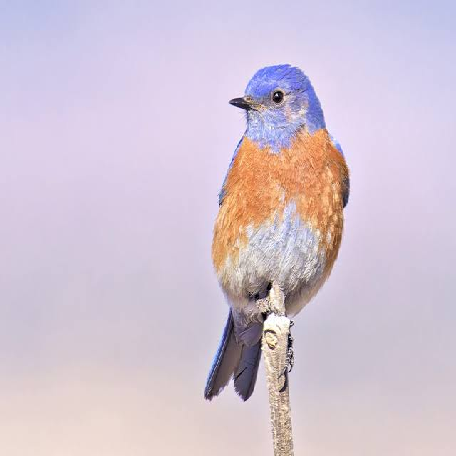

In [82]:
img_path5 = "/content/นก.jpg"
predict(img_path5, model_B5)
image.load_img(img_path5, target_size=(height, width))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[INFO]: Predict Classes ==> Cat With Probability 55.4853%


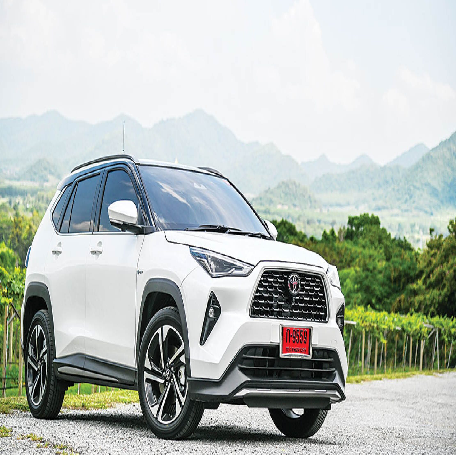

In [83]:
img_path6 = "/content/รถยนต์.jpg"
predict(img_path6, model_B5)
image.load_img(img_path6, target_size=(height, width))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[INFO]: Predict Classes ==> Cat With Probability 58.5291%


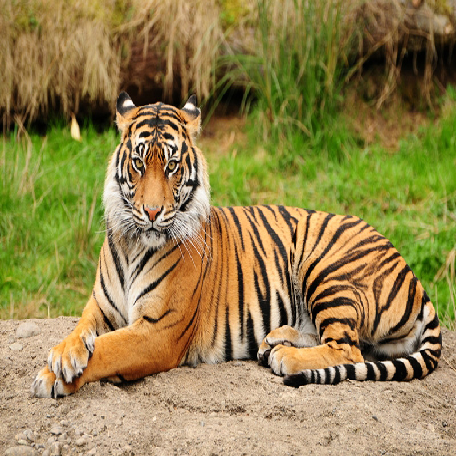

In [84]:
img_path7 = "/content/เสือ.jpg"
predict(img_path7, model_B5)
image.load_img(img_path7, target_size=(height, width))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[INFO]: Predict Classes ==> Cat With Probability 56.3617%


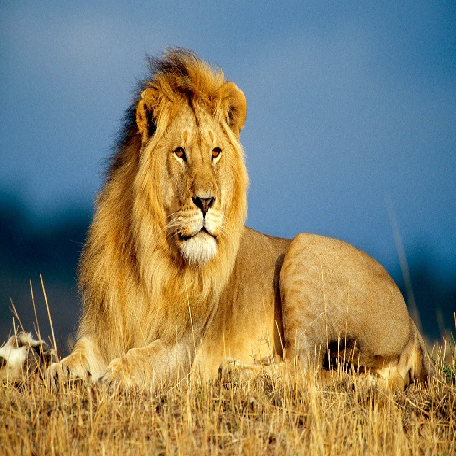

In [85]:
img_path8 = "/content/สิงโต.jpg"
predict(img_path8, model_B5)
image.load_img(img_path8, target_size=(height, width))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[INFO]: Predict Classes ==> Cat With Probability 56.7294%


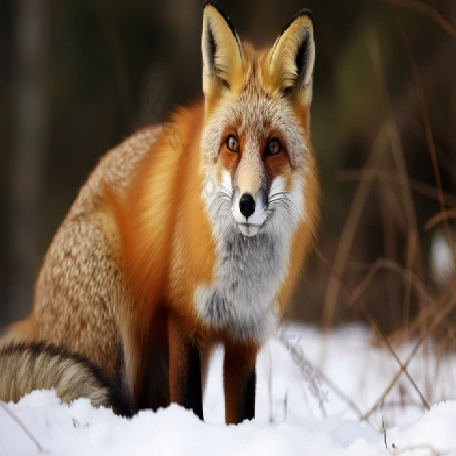

In [86]:
img_path9 = "/content/สุนัขจิ้งจอก.jpg"
predict(img_path9, model_B5)
image.load_img(img_path9, target_size=(height, width))

# Exercise

Print output ของ network

In [90]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

model_dir = "/content/drive/MyDrive/EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5"
model_B5 = load_model(model_dir)
height = width = model_B5.input_shape[1]
print(height, width)
model_B5.summary()

image_paths = [
    "/content/นก.jpg",
    "/content/รถยนต์.jpg",
    "/content/เสือ.jpg",
    "/content/สิงโต.jpg",
    "/content/สุนัขจิ้งจอก.jpg"
]

for img_path in image_paths:
  if os.path.exists(img_path):
      print(f"Predicting for image: {img_path}")
      predict(img_path, model_B5)
      image.load_img(img_path, target_size=(height, width))
  else:
      print(f"File not found: {img_path}")

456 456


Model: "EffNet_Cat_Dog"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 456, 456, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 228, 228, 48)   │          1,296 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 228, 228, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 228, 228, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 228, 228, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 228, 228, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 228, 228, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 228, 228, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 228, 228, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn   

 Total params: 28,517,620 (108.79 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 28,513,520 (108.77 MB)

 Optimizer params: 2 (12.00 B)

Predicting for image: /content/นก.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
[INFO]: Predict Classes ==> Cat With Probability 49.9352%
Predicting for image: /content/รถยนต์.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[INFO]: Predict Classes ==> Cat With Probability 55.4853%
Predicting for image: /content/เสือ.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[INFO]: Predict Classes ==> Cat With Probability 58.5291%
Predicting for image: /content/สิงโต.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[INFO]: Predict Classes ==> Cat With Probability 56.3617%
Predicting for image: /content/สุนัขจิ้งจอก.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[INFO]: Predict Classes ==> Cat With Probability 56.7294%


--------------------------------------------------------------------------------------

## Evaluating Model Performance

- Confusion matrix

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
# label_dict = {0: 'Cat', 1: 'Dog'}
# print(label_dict)

label_dict = dict((v,k) for k,v in labels.items())
print(label_dict)

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])

    return result[0]

In [ ]:
#Predict
pred_list = list()
prob_list = list()
img_path=X_test['filename'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(label_dict[result])
    prob_list.append(predict[result])

In [ ]:
predict

In [ ]:
print(len(pred_list))
print(len(prob_list))

X_test['category'] = pred_list
X_test['Prob'] = prob_list
X_test.head()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = X_test['label'].array
pred = X_test['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

## Confusion matrix

In [ ]:
#create CF
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

---------------------------------------

In [ ]:
img_path=X_test['filename'].tolist()
img_x  = predict_image(img_path[0])
img_x

In [ ]:
image.load_img(img_path[0], target_size=(height, width))